<a href="https://colab.research.google.com/github/eeolga/article/blob/main/Tool_performance_predicted_actual.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

New visualization that shows how well the predicted tool performance (from the fitted model) aligns with the actual performance


--- Fitted Parameters ---
Alpha (tool_weight): 1.0516
Beta (ECTS_weight): 0.7738
Gamma (log_weight shift): -0.0079
Results saved to 'output_10.xlsx'.

--- Data Model Validity Analysis ---
Missing Values Before Cleaning:
 tool_code             0
tool                  0
activity              0
level                 0
level_index           0
tool_weight           0
ECTS_weight           0
logs                  0
log_weight            0
tool_performance      0
Wt_ECTS               0
fitted_performance    0
dtype: int64
Pearson Correlation (Wt_ECTS vs Log Weight): 0.985
Spearman Correlation (Wt_ECTS vs Log Weight): 1.000


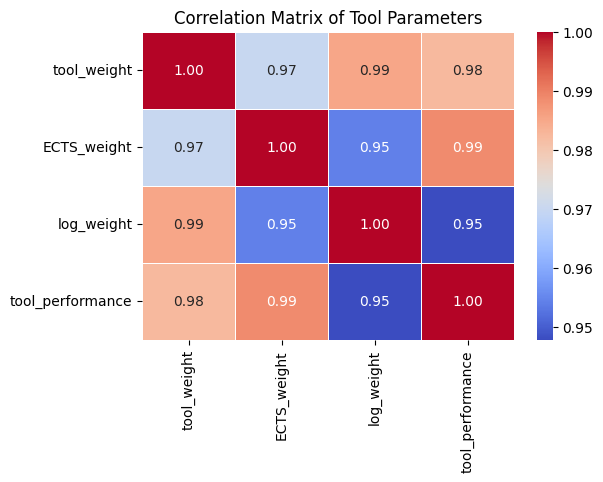

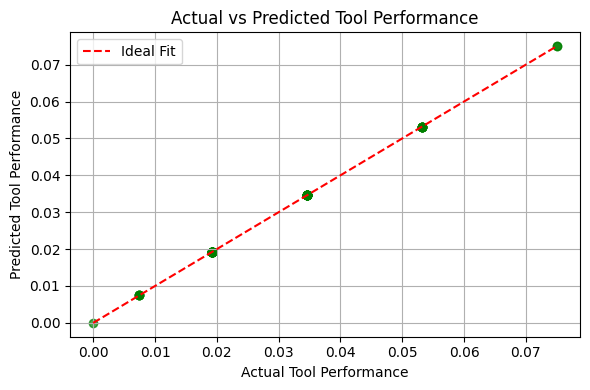

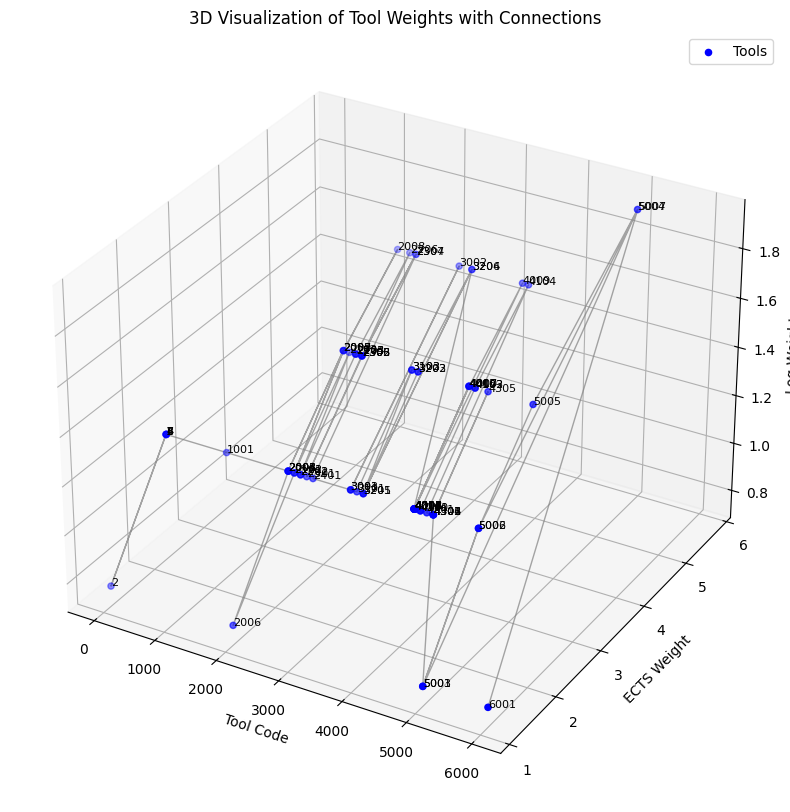

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import pearsonr, spearmanr
from scipy.optimize import curve_fit

def calculate_weight(level_index, total_level_index):
    return (level_index / total_level_index) * 234 if total_level_index != 0 else 0

def analyze_validity(df):
    print("\n--- Data Model Validity Analysis ---")

    # Checking for missing values
    missing_values = df.isnull().sum()
    print("Missing Values Before Cleaning:\n", missing_values)

    # Checking for correlations between weighted parameters
    if 'Wt_ECTS' in df.columns and 'log_weight' in df.columns:
        pearson_corr, _ = pearsonr(df['Wt_ECTS'].dropna(), df['log_weight'].dropna())
        spearman_corr, _ = spearmanr(df['Wt_ECTS'].dropna(), df['log_weight'].dropna())
        print(f"Pearson Correlation (Wt_ECTS vs Log Weight): {pearson_corr:.3f}")
        print(f"Spearman Correlation (Wt_ECTS vs Log Weight): {spearman_corr:.3f}")
    else:
        print("Required weighted columns are missing in the dataset.")

def visualize_correlations(df):
    plt.figure(figsize=(6, 4))
    correlation_matrix = df[['tool_weight', 'ECTS_weight', 'log_weight', 'tool_performance']].corr()
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
    plt.title("Correlation Matrix of Tool Parameters")
    plt.show()

def model(X, alpha, beta, gamma):
    tool_weight, ects_weight, tool_log = X
    eps = 1e-6
    numerator = (tool_weight + eps)**alpha * (ects_weight + eps)**beta
    denominator = np.log(1 + tool_log + eps) + gamma
    return numerator / denominator

def fit_model(df):
    # Before assigning to x_data and y_data, replace inf with NaN
    df.replace([np.inf, -np.inf], np.nan, inplace=True)

    # Drop rows with NaN values in any of the relevant columns
    df.dropna(subset=['tool_weight', 'ECTS_weight', 'log_weight', 'tool_performance'], inplace=True)

    x_data = np.array([
        df['tool_weight'].values,
        df['ECTS_weight'].values,
        df['log_weight'].values
    ])
    y_data = df['tool_performance'].values

    initial_guess = [1.0, 1.0, 1.0]
    params, _ = curve_fit(model, x_data, y_data, p0=initial_guess)

    alpha_fitted, beta_fitted, gamma_fitted = params
    print(f"\n--- Fitted Parameters ---")
    print(f"Alpha (tool_weight): {alpha_fitted:.4f}")
    print(f"Beta (ECTS_weight): {beta_fitted:.4f}")
    print(f"Gamma (log_weight shift): {gamma_fitted:.4f}")

    return alpha_fitted, beta_fitted, gamma_fitted

def visualize_predictions(df):
    plt.figure(figsize=(6, 4))
    plt.scatter(df['tool_performance'], df['fitted_performance'], alpha=0.7, color='green')
    plt.plot([df['tool_performance'].min(), df['tool_performance'].max()],
             [df['tool_performance'].min(), df['tool_performance'].max()], 'r--', label='Ideal Fit')
    plt.xlabel('Actual Tool Performance')
    plt.ylabel('Predicted Tool Performance')
    plt.title('Actual vs Predicted Tool Performance')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def main():
    input_file = "/content/data_EPX_05042025.xlsx"
    output_file = "output_10.xlsx"

    try:
        df = pd.read_excel(input_file)
    except FileNotFoundError:
        print(f"Error: File '{input_file}' not found.")
        return

    # Instead of median, use mode or a specific value to fill missing values in 'level' column
    df.fillna({
        'tool': 'Unknown',
        'level': df['level'].mode()[0],  # Use mode for 'level' column
        'assessment': 'Not Available',
        'level_index': df['level_index'].median(),
    }, inplace=True)

    # Ensure 'tool_weight' and 'ECTS_weight' are numeric
    df['tool_weight'] = pd.to_numeric(df['tool_weight'], errors='coerce')
    df['ECTS_weight'] = pd.to_numeric(df['ECTS_weight'], errors='coerce')

    if 'level_index' not in df.columns or 'tool_code' not in df.columns:
        print("Error: Required columns ('level_index', 'tool_code') not found in the Excel file.")
        return

    total_level_index = df['level_index'].sum()

    df['Wt_ECTS'] = df['level_index'].apply(lambda x: calculate_weight(x, total_level_index))
    df['log_weight'] = np.log1p(df['Wt_ECTS'])

    df['tool_performance'] = (df['tool_weight'] * df['ECTS_weight']) / df['log_weight']

    alpha_fitted, beta_fitted, gamma_fitted = fit_model(df)

    df['fitted_performance'] = model(
        [df['tool_weight'].values, df['ECTS_weight'].values, df['log_weight'].values],
        alpha_fitted, beta_fitted, gamma_fitted
    )

    df.to_excel(output_file, index=False)
    print(f"Results saved to '{output_file}'.")

    analyze_validity(df)
    visualize_correlations(df)
    visualize_predictions(df)

    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')

    x = df['tool_code']
    y = df['Wt_ECTS']
    z = df['log_weight']

    ax.scatter(x, y, z, c='blue', marker='o', label='Tools')
    ax.plot(x, y, z, color='gray', linestyle='-', linewidth=1, alpha=0.7)

    for i, txt in enumerate(df['tool_code']):
        ax.text(x.iloc[i], y.iloc[i], z.iloc[i], txt, size=8, color='black')

    ax.set_xlabel('Tool Code')
    ax.set_ylabel('ECTS Weight')
    ax.set_zlabel('Log Weight')
    ax.set_title('3D Visualization of Tool Weights with Connections')
    ax.legend()

    plt.show()

if __name__ == "__main__":
    main()